### May 21, 2025 Pico PID control loop Hysteresis test

In [61]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob, csv
from matplotlib.ticker import AutoMinorLocator

In [62]:
%matplotlib widget

In [63]:
def load_csv(filename):
    data = {
        "host_epoch": [],
        "pico_epoch": [],
        "temp": [],
        "set_c": [],
        "drive": []
    }
    with open(filename, "r") as f:
        reader = csv.reader(f)
        header = next(reader, None)  # Skip the header
        for row in reader:
            if not row or row[0].startswith("!"):
                continue
            try:
                data["host_epoch"].append(float(row[0]))
                data["pico_epoch"].append(float(row[1]))
                data["temp"].append(float(row[2]))
                data["set_c"].append(float(row[3]))
                data["drive"].append(float(row[4]))
            except (ValueError, IndexError):
                continue
    return data

data_dir = "/Users/rs_mbpro14/RAL/EIGSEP_github/eigsep-sensors/scripts/pico_pid_log.csv"
# csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
data = load_csv(data_dir)
## if multiple .csv
# all_data = {}
# for file in csv_files:
#     fname = os.path.basename(file)
#     all_data[fname] = load_csv(file)

In [71]:
all_data = {"pico_pid_log.csv": data}
all_data['pico_pid_log.csv'].keys()

dict_keys(['host_epoch', 'pico_epoch', 'temp', 'set_c', 'drive'])

In [100]:
def plot_data(all_data, title="Temperature vs Time", xlim=None, ylim=None):
    """
    Plots temp. vs time
    Parameters
    ----------
    all_data : dict
        Dictionary of {filename: {"pico_epoch": [...], "temp": [...]}}.
    title : str
    xlim : tuple or None
        Time axis limits in seconds.
    ylim : tuple or None
        Temperature axis limits (e.g., (20, 40)).
    """
    sns.set_context("paper")
    sns.set_style("whitegrid")
    sns.set_palette("colorblind")

    fig, ax = plt.subplots(figsize=(12, 6))

    # # Sort for reproducibility
    # for fname, dataset in sorted(all_data.items()):
    #     time_s = dataset["pico_epoch"]
    #     temperature = dataset["temp"]
    #     sns.lineplot(x=time_s, y=temperature, label=os.path.splitext(fname)[0], ax=ax, lw=2.0)

    set_c_value = None

    # Sort for reproducibility
    for fname, dataset in sorted(all_data.items()):
        time_s = dataset["pico_epoch"]
        temperature = dataset["temp"]

        if "set_c" in dataset and dataset["set_c"]:
            set_c_value = dataset["set_c"][0]
            duty_value  = dataset["drive"]
        sns.lineplot(x=time_s, y=temperature, label=os.path.splitext(fname)[0], ax=ax, lw=2.0)
        # sns.lineplot(x=time_s, y=duty_value)

    if set_c_value is not None:
        ax.axhline(y=set_c_value, color='salmon', linestyle='-', linewidth=2, alpha=0.5,
                   label=f"Setpoint {set_c_value:.1f}°C")

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Temperature (˚C)", fontsize=12)

    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(axis='both', which='major', direction='in', length=6, width=1, bottom=True, left=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=3, width=0.8, bottom=True, left=True)

    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

    ax.legend(
        title="Hysteresis: +/- 1˚C",
        fontsize=11,
        ncol=3,
        title_fontsize=11,
        loc="upper right",
        borderaxespad=0,
        frameon=True
    )
    fig.tight_layout()
    plt.show()


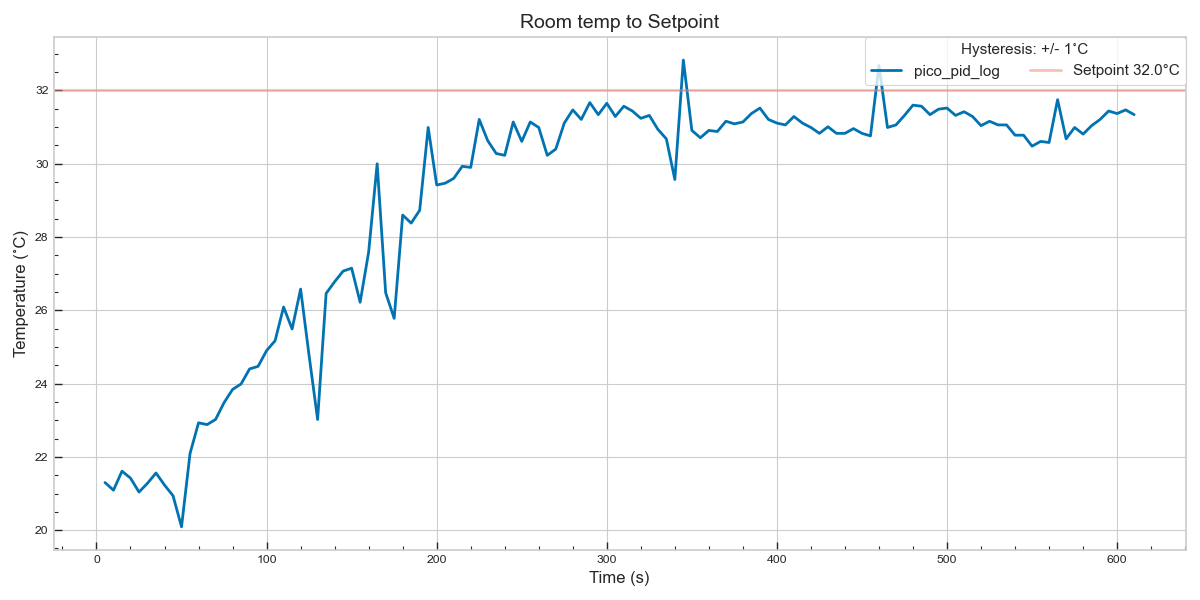

In [101]:
plot_data(all_data, title="Room temp to Setpoint")

In [128]:


def plot_data_with_duty(all_data, title="Temperature and Duty vs Time", xlim=None, ylim=None):
    """
    Plots temperature and duty cycle vs. time for one or more CSV datasets.
    """
    sns.set_context("paper")
    sns.set_style("whitegrid")
    sns.set_palette("colorblind")

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True, 
                            gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})

    set_c_value = None

    for fname, dataset in sorted(all_data.items()):
        time_s = dataset["pico_epoch"]
        temperature = dataset["temp"]
        duty = dataset.get("drive", None)

        # Top plot: temperature
        sns.lineplot(x=time_s, y=temperature, label=os.path.splitext(fname)[0], ax=axs[0], lw=2.0)
        # Extract and draw setpoint
        if "set_c" in dataset and dataset["set_c"]:
            set_c_value = dataset["set_c"][0]
        if set_c_value is not None:
            axs[0].axhline(y=set_c_value, color='red', linestyle='--', linewidth=2,
                           label=f"Setpoint {set_c_value:.1f}°C")

        # Bottom plot: duty
        if duty is not None:
            sns.lineplot(x=time_s, y=duty, label=os.path.splitext(fname)[0], ax=axs[1], lw=1.3)
    
    # -- Format temperature plot
    axs[0].set_title(title, fontsize=14)
    axs[0].set_ylabel("Temperature (˚C)", fontsize=12)
    if ylim:
        axs[0].set_ylim(*ylim)
    axs[0].xaxis.set_minor_locator(AutoMinorLocator())
    axs[0].yaxis.set_minor_locator(AutoMinorLocator())
    axs[0].tick_params(axis='both', which='major', direction='in', length=6, width=1, bottom=True, left=True)
    axs[0].tick_params(axis='both', which='minor', direction='in', length=3, width=0.8, bottom=True, left=True)
    for spine in axs[0].spines.values():
        spine.set_linewidth(1.2)
    axs[0].legend(
        title="Hysteresis: +/- 1˚C",
        fontsize=11,
        ncol=2,
        title_fontsize=11,
        loc="lower right",
        borderaxespad=0,
        frameon=True
    )

    # -- Format duty plot
    axs[1].set_ylabel("Duty", fontsize=12)
    axs[1].set_xlabel("Time (s)", fontsize=12)
    axs[1].set_ylim(-0.5, 0.5)  # Adjust if your duty cycle range is known
    axs[1].xaxis.set_minor_locator(AutoMinorLocator())
    axs[1].yaxis.set_minor_locator(AutoMinorLocator())
    axs[1].tick_params(axis='both', which='major', direction='in', length=6, width=1, bottom=True, left=True)
    axs[1].tick_params(axis='both', which='minor', direction='in', length=3, width=0.8, bottom=True, left=True)
    for spine in axs[1].spines.values():
        spine.set_linewidth(1.2)
    axs[1].legend([],[], frameon=False)  # no legend for duty

    if xlim:
        axs[1].set_xlim(*xlim)

    # fig.tight_layout()
    plt.show()


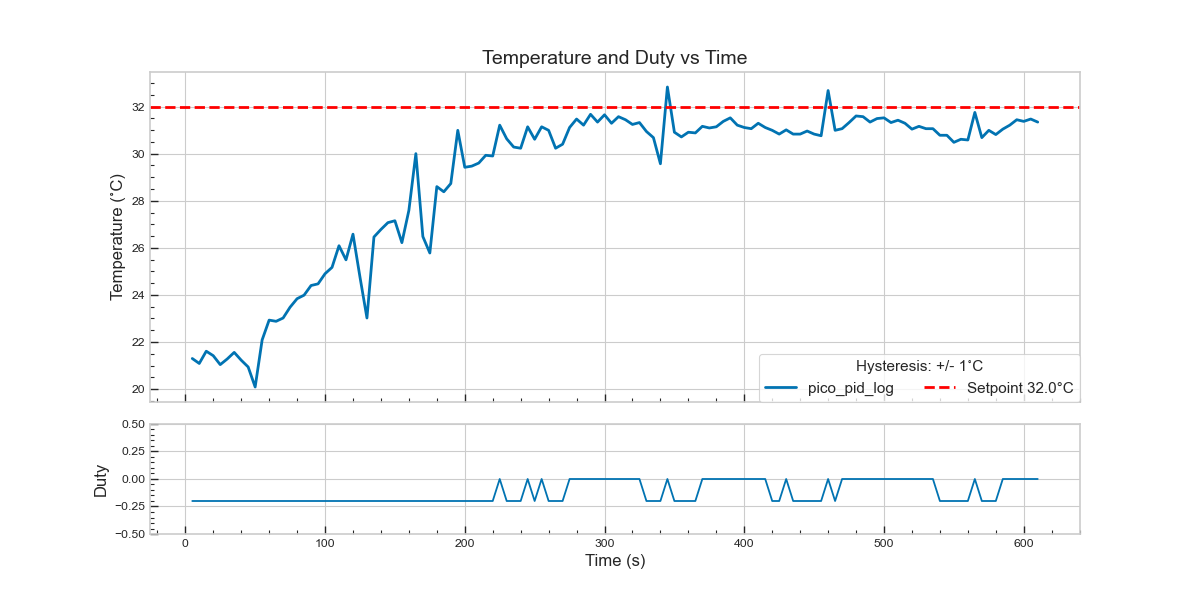

In [129]:
plot_data_with_duty(all_data)